In [2]:
import pandas as pd
import numpy as np
from ta.momentum import StochasticOscillator
from ta.volatility import BollingerBands
from ta.trend import MACD
import warnings
warnings.filterwarnings('ignore')

In [5]:
df=pd.read_csv('crypto.csv')

In [6]:
df.head()

,Date,Open (BTC),High (BTC),Low (BTC),Close (BTC),Volume (BTC),Open (USDT),High (USDT),Low (USDT),Close (USDT),Volume (USDT)
0,2019-01-03 00:00:00+00:00,3931.048584,3935.685059,3826.222900,3836.741211,4530215219,1.020654,1.026825,1.018287,1.019473,3487202823
1,2019-01-04 00:00:00+00:00,3832.040039,3865.934570,3783.853760,3857.717529,4847965467,1.023557,1.024858,1.010810,1.017200,3895786727
2,2019-01-05 00:00:00+00:00,3851.973877,3904.903076,3836.900146,3845.194580,5137609824,1.015526,1.026343,1.010341,1.018489,3993806914
3,2019-01-06 00:00:00+00:00,3836.519043,4093.297363,3826.513184,4076.632568,5597027440,1.018144,1.026202,1.004842,1.023578,4224650070
4,2019-01-07 00:00:00+00:00,4078.584961,4092.613525,4020.894043,4025.248291,5228625637,1.022354,1.024765,1.012342,1.013987,3761972510


In [7]:
df=df[['Date','Open (BTC)', 'High (BTC)', 'Low (BTC)', 'Close (BTC)',
       'Volume (BTC)']]

# Feature Extraction

In [8]:
#target column
df['Target'] = df['Close (BTC)'].shift(-1)

In [9]:
df['Close_Log'] = np.log1p(df['Close (BTC)'])

In [10]:
def calculate_rsi(data, window=14):
    diff = data.diff(1)
    gain = diff.where(diff > 0, 0)
    loss = -diff.where(diff < 0, 0)

    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    
    return rsi.reindex(data.index)

def calculate_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()

    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    
    return macd, signal


def calculate_bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data.rolling(window=window).mean()
    rolling_std = data.rolling(window=window).std()

    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    
    return upper_band.reindex(data.index), lower_band.reindex(data.index)

In [11]:
df['RSI'] = calculate_rsi(df['Close_Log'])

In [12]:
df['MACD'], df['Signal'] = calculate_macd(df['Close_Log'])

In [13]:
df['Upper_Band'], df['Lower_Band'] = calculate_bollinger_bands(df['Close_Log'])
df['Band_Width'] = df['Upper_Band'] - df['Lower_Band']

In [14]:
# Stochastic Oscillator
stoch = StochasticOscillator(high=df['High (BTC)'], low=df['Low (BTC)'], close=df['Close_Log'])
df['Stochastic_Oscillator'] = stoch.stoch()

# Volume Rate of Change
df['Volume_RoC'] = df['Volume (BTC)'].pct_change()

# On-Balance Volume (OBV)
df['OBV'] = (np.sign(df['Close_Log'].diff()) * df['Volume (BTC)']).cumsum()

# Historical Volatility
#df['Historical_Volatility'] = df['Close_Log'].pct_change().rolling(window=20).std() * np.sqrt(252)

# Implied Volatility
# You may need an option pricing model for this feature, as it's typically derived from option prices.

# Moving Average of Volume
df['Volume_MA'] = df['Volume (BTC)'].rolling(window=10).mean()

# Bollinger Bands
bb = BollingerBands(close=df['Close_Log'])
df['BB_High'] = bb.bollinger_hband()
df['BB_Low'] = bb.bollinger_lband()

# Exponential Moving Average (EMA)
df['EMA'] = df['Close_Log'].ewm(span=10, adjust=False).mean()

# Rate of Change (ROC)
df['ROC'] = df['Close_Log'].pct_change()

# Volume Weighted Average Price (VWAP)
df['VWAP'] = (df['Close_Log'] * df['Volume (BTC)']).cumsum() / df['Volume (BTC)'].cumsum()


In [15]:
# Assuming 'Close (BTC)' is the column you want to calculate SMAs for
df['SMA_10'] = df['Close (BTC)'].rolling(window=10).mean()
df['SMA_50'] = df['Close (BTC)'].rolling(window=50).mean()

In [16]:
df.columns

Index(['Date', 'Open (BTC)', 'High (BTC)', 'Low (BTC)', 'Close (BTC)',
       'Volume (BTC)', 'Target', 'Close_Log', 'RSI', 'MACD', 'Signal',
       'Upper_Band', 'Lower_Band', 'Band_Width', 'Stochastic_Oscillator',
       'Volume_RoC', 'OBV', 'Volume_MA', 'BB_High', 'BB_Low', 'EMA', 'ROC',
       'VWAP', 'SMA_10', 'SMA_50'],
      dtype='object')

In [17]:
df.isnull().sum()

Date                      0
Open (BTC)                0
High (BTC)                0
Low (BTC)                 0
Close (BTC)               0
Volume (BTC)              0
Target                    1
Close_Log                 0
RSI                       1
MACD                      0
Signal                    0
Upper_Band               19
Lower_Band               19
Band_Width               19
Stochastic_Oscillator    13
Volume_RoC                1
OBV                       1
Volume_MA                 9
BB_High                  19
BB_Low                   19
EMA                       0
ROC                       1
VWAP                      0
SMA_10                    9
SMA_50                   49
dtype: int64

In [18]:
df.dropna(inplace=True)

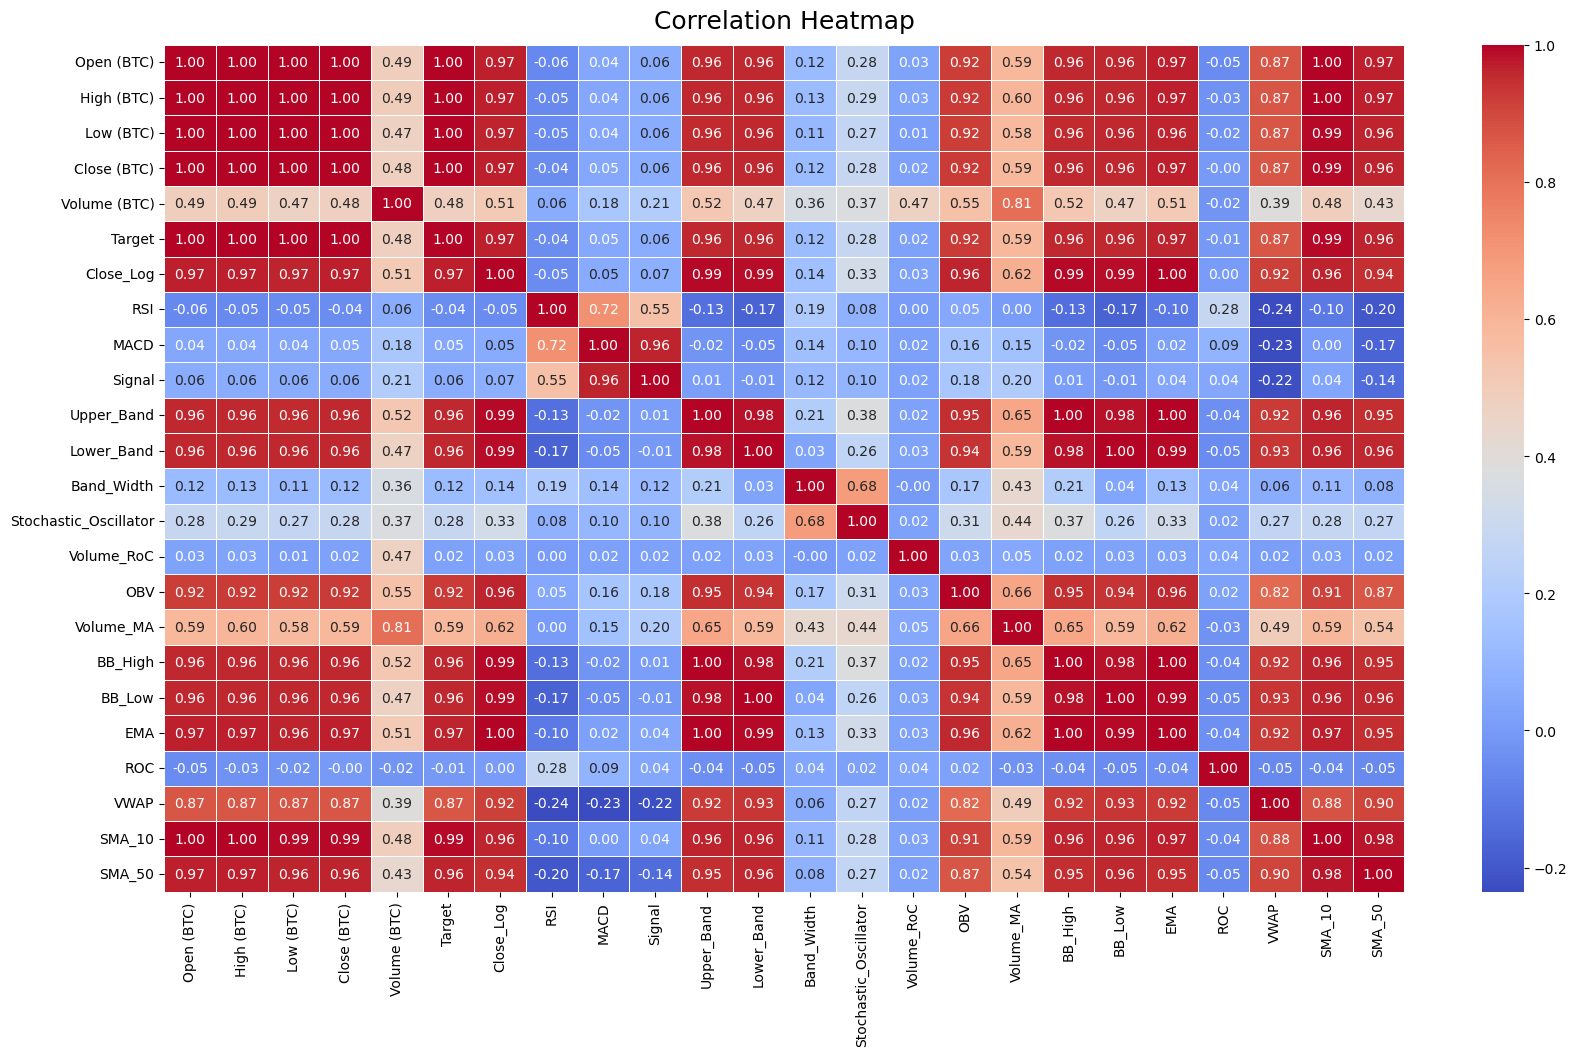

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
plt.figure(figsize=(20, 11))
heatmap = sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 18}, pad=12)
plt.show()

In [20]:
# Choose features for X and y
X_cols = ['Close_Log', 'RSI', 'MACD', 'Signal','Band_Width', 'Stochastic_Oscillator',
       'Volume_RoC', 'OBV', 'Volume_MA', 'BB_High', 'BB_Low', 'EMA', 'ROC',
       'VWAP', 'SMA_10', 'SMA_50']
y_col = 'Target'

# Create input features (X) and target variable (y)
X = df[X_cols]
y = df[y_col]

In [21]:
X

,Close_Log,RSI,MACD,Signal,Band_Width,Stochastic_Oscillator,Volume_RoC,OBV,Volume_MA,BB_High,BB_Low,EMA,ROC,VWAP,SMA_10,SMA_50
49,8.282766,84.817050,0.022287,0.009131,0.195408,-545.730377,-0.105626,3.012213e+10,7.456689e+09,8.297448,8.106988,8.243850,-0.001385,8.210159,3764.366211,3669.866196
50,8.295680,78.638813,0.025315,0.012368,0.209247,-892.749498,0.006610,3.794866e+10,7.591303e+09,8.310636,8.106687,8.253273,0.001559,8.212367,3799.566016,3673.241904
51,8.329303,82.348919,0.030081,0.015911,0.227690,-644.368660,0.140002,4.687092e+10,7.839638e+09,8.328566,8.106641,8.267097,0.004053,8.215709,3850.611646,3678.938091
52,8.245759,56.047447,0.026808,0.018090,0.219457,-596.979637,0.209809,3.607669e+10,8.291957e+09,8.329388,8.115488,8.263217,-0.010030,8.216714,3869.966309,3678.242749
53,8.264543,61.418388,0.025436,0.019559,0.211738,-596.976522,-0.136687,4.539549e+10,8.614641e+09,8.331296,8.124919,8.263458,0.002278,8.218055,3896.154858,3674.364023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1119,10.514696,22.157445,-0.062644,-0.054061,0.295913,-299.012598,0.185272,1.483701e+12,2.959355e+10,10.751937,10.463516,10.549713,-0.000262,9.949295,38527.575391,44901.739062
1120,10.522429,26.590379,-0.061087,-0.055466,0.304202,-314.721120,-0.200583,1.508742e+12,2.992860e+10,10.750354,10.453855,10.544752,0.000736,9.949691,38016.343750,44634.407813
1121,10.539676,27.917513,-0.057796,-0.055932,0.307005,-314.720956,-0.111918,1.530981e+12,2.991076e+10,10.746750,10.447518,10.543829,0.001639,9.950053,37557.213672,44436.652031
1122,10.548997,29.691646,-0.053815,-0.055509,0.306644,-323.557188,-0.226840,1.548175e+12,2.932103e+10,10.741856,10.442977,10.544769,0.000884,9.950337,37196.598828,44254.549531


In [22]:
y

49       4005.526611
50       4142.526855
51       3810.427490
52       3882.696289
53       3854.357910
            ...     
1119    37138.234375
1120    37784.332031
1121    38138.179688
1122    37917.601562
1123    38483.125000
Name: Target, Length: 1075, dtype: float64

In [23]:
from sklearn.preprocessing import MinMaxScaler

# Scale features using Min-Max scaling
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Scale target variable using Min-Max scaling
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [24]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)

In [25]:
# Reshape input data for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [26]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(units=50, activation='relu', return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(units=60, activation='relu', return_sequences=True)))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=80, activation='relu', return_sequences=True)))
model.add(Dropout(0.4))
model.add(Bidirectional(LSTM(units=120, activation='relu', return_sequences=True)))
model.add(Dropout(0.5))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [27]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
27/27 [==============================] - 30s 148ms/step - loss: 0.0763 - val_loss: 0.1193
Epoch 2/50
27/27 [==============================] - 1s 33ms/step - loss: 0.0320 - val_loss: 0.0099
Epoch 3/50
27/27 [==============================] - 1s 31ms/step - loss: 0.0093 - val_loss: 0.0030
Epoch 4/50
27/27 [==============================] - 1s 34ms/step - loss: 0.0068 - val_loss: 0.0158
Epoch 5/50
27/27 [==============================] - 1s 31ms/step - loss: 0.0064 - val_loss: 0.0187
Epoch 6/50
27/27 [==============================] - 1s 36ms/step - loss: 0.0061 - val_loss: 0.0015
Epoch 7/50
27/27 [==============================] - 1s 34ms/step - loss: 0.0056 - val_loss: 0.0047
Epoch 8/50
27/27 [==============================] - 1s 33ms/step - loss: 0.0049 - val_loss: 0.0203
Epoch 9/50
27/27 [==============================] - 1s 31ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 10/50
27/27 [==============================] - 1s 31ms/step - loss: 0.0047 - val_loss: 0.0062
Epoch 1

In [28]:
y_pred = model.predict(X_test)

7/7 [==============================] - 3s 9ms/step


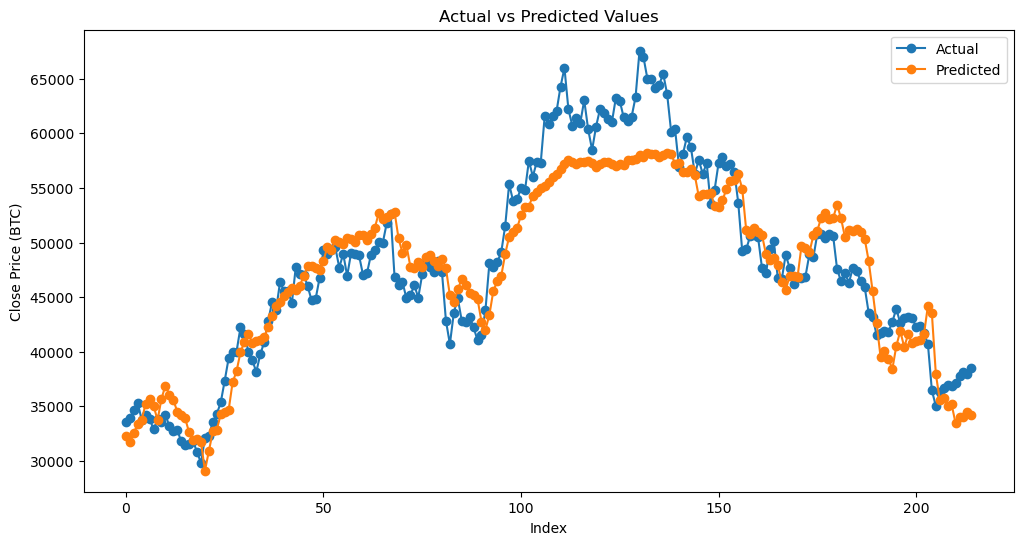

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Inverse transform the predicted and actual values
y_pred_original = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test)

# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual', marker='o')
plt.plot(y_pred_original, label='Predicted', marker='o')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price (BTC)')
plt.legend()
plt.show()


In [31]:
from sklearn.metrics import r2_score

# Calculate R2 score
r2score = r2_score(y_test_original, y_pred_original)

# Print R2 score
print("R2 Score:", r2score)

R2 Score: 0.8748780952091566


In [32]:
model.save('lstm_86_per.h5')

# Hyper paramter tuning

In [33]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameter
from keras.optimizers import Adam

def build_model(hp):
    model = Sequential()

    # Number of LSTM units in the first layer
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=256, step=32)
    model.add(Bidirectional(LSTM(units=hp_units_1, activation='relu', return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    # Number of LSTM units in the second layer
    hp_units_2 = hp.Int('units_2', min_value=32, max_value=256, step=32)
    model.add(Bidirectional(LSTM(units=hp_units_2, activation='relu', return_sequences=True)))
    model.add(Dropout(0.3))

    # Number of LSTM units in the third layer
    hp_units_3 = hp.Int('units_3', min_value=32, max_value=256, step=32)
    model.add(Bidirectional(LSTM(units=hp_units_3, activation='relu', return_sequences=True)))
    model.add(Dropout(0.4))

    # Number of LSTM units in the fourth layer
    hp_units_4 = hp.Int('units_4', min_value=32, max_value=256, step=32)
    model.add(Bidirectional(LSTM(units=hp_units_4, activation='relu', return_sequences=True)))
    model.add(Dropout(0.5))

    model.add(Dense(units=1))

    # Compile the model with a variable learning rate
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Adam(learning_rate=hp_learning_rate), loss='mean_squared_error')

    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,  # You can adjust this based on the resources and time available
    directory='hyperparameter_tuning',
    project_name='lstm_hyperparameter_tuning'
)

tuner.search(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)

Trial 10 Complete [00h 04m 01s]
val_loss: 0.0011486734729260206

Best val_loss So Far: 0.0011486734729260206
Total elapsed time: 00h 21m 41s


In [34]:
# Get the best hyperparameters
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters.values

# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters)

Best Hyperparameters:
{'units_1': 160, 'units_2': 256, 'units_3': 256, 'units_4': 192, 'learning_rate': 0.0001}


In [39]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Save the entire model
best_model.save('best_lstm_model_last_1.h5')

In [40]:
#predicting using best model
y_pred1 = best_model.predict(X_test)

7/7 [==============================] - 3s 25ms/step


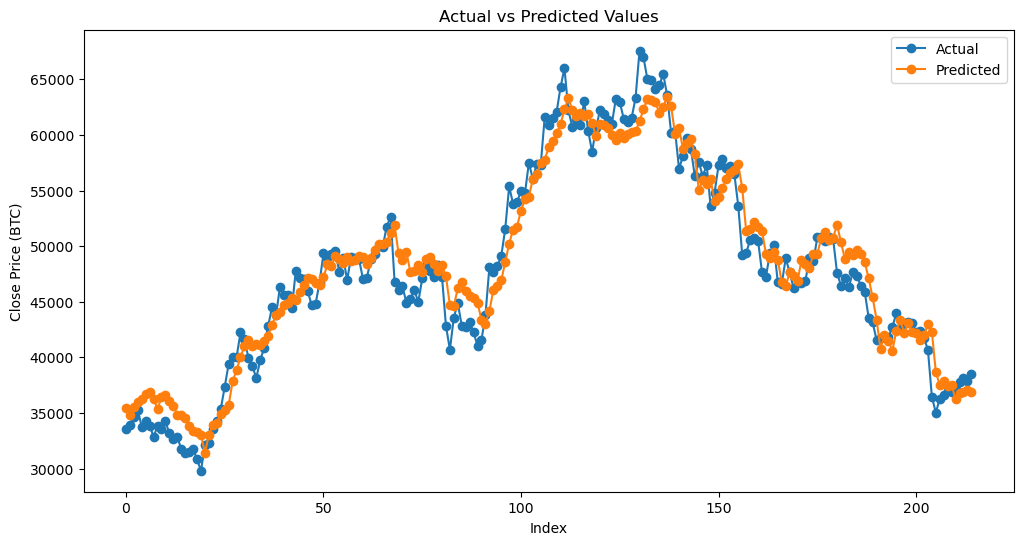

In [41]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# Inverse transform the predicted and actual values
y_pred_original = scaler_y.inverse_transform(y_pred1.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test)

# Plotting actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label='Actual', marker='o')
plt.plot(y_pred_original, label='Predicted', marker='o')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Close Price (BTC)')
plt.legend()
plt.show()

In [42]:
from sklearn.metrics import r2_score

# Calculate R2 score
r2score = r2_score(y_test_original, y_pred_original)

# Print R2 score
print("R2 Score:", r2score)

R2 Score: 0.944107877282841
